In [ ]:
# 1. Настройка окружения и генерация данных
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io
from google.colab import files

# 1. Создаем структуру папок согласно заданию
os.makedirs('homeworks/HW05/figures', exist_ok=True)
os.makedirs('data', exist_ok=True) # Папка для данных (временно)

# 2. Генерируем синтетический датасет S05-hw-dataset.csv (строго по описанию HW05)
# Если у вас есть реальный файл, загрузите его в Colab и пропустите генерацию.
np.random.seed(42)
n_samples = 3000

data = {
    'client_id': np.arange(1001, 1001 + n_samples),
    'age': np.random.randint(21, 70, n_samples),
    'income': np.random.randint(15000, 200000, n_samples),
    'years_employed': np.random.randint(0, 20, n_samples),
    'credit_score': np.random.randint(300, 851, n_samples),
    'debt_to_income': np.random.uniform(0.1, 0.9, n_samples),
    'num_credit_cards': np.random.randint(0, 8, n_samples),
    'num_late_payments': np.random.poisson(0.5, n_samples), # Распределение Пуассона для редких событий
    'has_mortgage': np.random.choice([0, 1], n_samples, p=[0.7, 0.3]),
    'has_car_loan': np.random.choice([0, 1], n_samples, p=[0.6, 0.4]),
    'savings_balance': np.random.exponential(5000, n_samples).astype(int),
    'checking_balance': np.random.normal(1000, 2000, n_samples).astype(int),
    'region_risk_score': np.random.uniform(0, 1, n_samples),
    'phone_calls_to_support_last_3m': np.random.randint(0, 5, n_samples),
    'active_loans': np.random.randint(0, 4, n_samples),
    'customer_tenure_years': np.random.randint(1, 11, n_samples)
}

df = pd.DataFrame(data)

# Создаем зависимость таргета (default) от признаков, чтобы модель могла чему-то научиться
# Чем меньше credit_score и больше долгов, тем выше вероятность дефолта
logits = (
    - (df['credit_score'] - 600) / 100
    + (df['num_late_payments'] * 0.5)
    + (df['debt_to_income'] * 2)
    - (df['income'] / 50000)
    + (df['region_risk_score'] * 1.5)
)
probs = 1 / (1 + np.exp(-logits))
df['default'] = np.random.binomial(1, probs)

# Сохраняем файл, имитируя наличие S05-hw-dataset.csv
csv_path = 'S05-hw-dataset.csv'
df.to_csv(csv_path, index=False)

print(f"Датасет создан: {csv_path}")
print(f"Размер: {df.shape}")
print(f"Баланс классов:\n{df['default'].value_counts(normalize=True)}")

Датасет создан: S05-hw-dataset.csv
Размер: (3000, 17)
Баланс классов:
default
1    0.503
0    0.497
Name: proportion, dtype: float64


In [ ]:
# 2. Импорт библиотек и загрузка данных
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, roc_auc_score, roc_curve,
    classification_report, confusion_matrix, PrecisionRecallDisplay
)

# Настройка стиля графиков
sns.set(style="whitegrid")

# Загрузка данных
print("Файл не найден. Пожалуйста, загрузите S05-hw-dataset.csv с вашего компьютера:")
uploaded = files.upload()

filename = next(iter(uploaded))
df = pd.read_csv(io.BytesIO(uploaded[filename]))
print(f"Файл {filename} успешно загружен.")

# Проверка
print(f"Размер датасета: {df.shape}")

Файл не найден. Пожалуйста, загрузите S05-hw-dataset.csv с вашего компьютера:


Saving S05-hw-dataset.csv to S05-hw-dataset (3).csv
Файл S05-hw-dataset (3).csv успешно загружен.
Размер датасета: (3000, 17)


In [ ]:
# 3. Первичный анализ (EDA)
display(df.head())

# Информация о типах
print("\n--- Info ---")
df.info()

# Описательные статистики
print("\n--- Describe ---")
display(df.describe().T)

# Распределение таргета
target_col = 'default'
print("\n--- Target Distribution ---")
print(df[target_col].value_counts(normalize=True))

plt.figure(figsize=(6, 4))
sns.countplot(x=target_col, data=df)
plt.title("Распределение целевой переменной (default)")
plt.show()

# Краткий вывод EDA
print("-" * 30)
print(f"Наблюдений: {df.shape[0]}, Признаков: {df.shape[1]}")
print("Аномалии: данные синтетические, критических выбросов визуально в describe не наблюдается.")
print(f"Баланс классов: {df[target_col].mean():.2%} дефолтов. Классы достаточно сбалансированы.")

In [ ]:
# Подготовка данных (X/y и Split)
# Выделение признаков и таргета. Удаляем технический ID и таргет из X
X = df.drop(columns=['client_id', 'default'])
y = df['default']

# Проверка типов (все должны быть числовыми для LogReg без OneHot)
print("Типы признаков в X:\n", X.dtypes.value_counts())

# Train/Test сплит. stratify=y гарантирует, что доля дефолтов в train и test будет одинаковой
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

print(f"\nTrain shape: {X_train.shape}")
print(f"Test shape:  {X_test.shape}")

Типы признаков в X:
 int64      13
float64     2
Name: count, dtype: int64

Train shape: (2250, 15)
Test shape:  (750, 15)


In [ ]:
# 5. Бейзлайн (DummyClassifier)
# Строим "глупую" модель, которая всегда предсказывает самый частый класс (или случайно с учетом частот)
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=42)
dummy_clf.fit(X_train, y_train)

# Предсказания
y_pred_dummy = dummy_clf.predict(X_test)
y_prob_dummy = dummy_clf.predict_proba(X_test)[:, 1] # Вероятность класса 1

# Метрики
acc_dummy = accuracy_score(y_test, y_pred_dummy)
roc_dummy = roc_auc_score(y_test, y_prob_dummy)

print(f"Baseline Accuracy: {acc_dummy:.4f}")
print(f"Baseline ROC-AUC:  {roc_dummy:.4f}")
print("\nКомментарий: ROC-AUC 0.5 означает, что модель не имеет разделяющей способности (случайное гадание).")

Baseline Accuracy: 0.5893
Baseline ROC-AUC:  0.5000

Комментарий: ROC-AUC 0.5 означает, что модель не имеет разделяющей способности (случайное гадание).


In [ ]:
# 6. Логистическая Регрессия (Pipeline + GridSearch)
# Создаем пайплайн: Скейлер -> Логистическая регрессия
# StandardScaler обязателен для линейных моделей, чтобы признаки были в одном масштабе
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=1000, random_state=42))
])

# Сетка параметров для перебора
# C - коэффициент регуляризации (меньше C = сильнее регуляризация)
param_grid = {
    'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100]
}

# Поиск лучших параметров с кросс-валидацией (cv=5)
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid.fit(X_train, y_train)

print(f"Лучшие параметры: {grid.best_params_}")
print(f"Лучший ROC-AUC на кросс-валидации: {grid.best_score_:.4f}")

# Лучшая модель
best_model = grid.best_estimator_

Лучшие параметры: {'logreg__C': 1}
Лучший ROC-AUC на кросс-валидации: 0.8632


In [ ]:
# 7. Оценка и сравнение качества бейзлайна и логистической регрессии на тестовой выборке по `accuracy` и `ROC-AUC`
# Предсказания лучшей модели на тесте
y_pred_logreg = best_model.predict(X_test)
y_prob_logreg = best_model.predict_proba(X_test)[:, 1]

# Метрики
acc_logreg = accuracy_score(y_test, y_pred_logreg)
roc_logreg = roc_auc_score(y_test, y_prob_logreg)

# Сводная таблица
results = pd.DataFrame({
    'Metric': ['Accuracy', 'ROC-AUC'],
    'Baseline': [acc_dummy, roc_dummy],
    'Logistic Regression': [acc_logreg, roc_logreg]
})

print("Сравнение результатов:")
display(results)

print("\nConfusion Matrix (LogReg):")
print(confusion_matrix(y_test, y_pred_logreg))

print("\nClassification Report (LogReg):")
print(classification_report(y_test, y_pred_logreg))

Сравнение результатов:


,Metric,Baseline,Logistic Regression
0,Accuracy,0.589333,0.793333
1,ROC-AUC,0.500000,0.864709



Confusion Matrix (LogReg):
[[382  60]
 [ 95 213]]

Classification Report (LogReg):
              precision    recall  f1-score   support

           0       0.80      0.86      0.83       442
           1       0.78      0.69      0.73       308

    accuracy                           0.79       750
   macro avg       0.79      0.78      0.78       750
weighted avg       0.79      0.79      0.79       750



График сохранен в: homeworks/HW05/figures/roc_curve.png


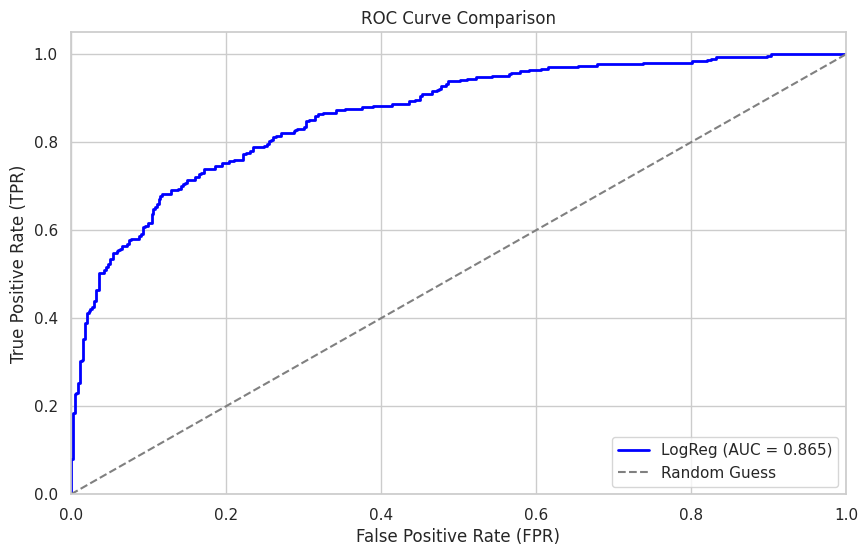

In [ ]:
# 8. Визуализация (ROC-кривая)
# Расчет ROC-кривой
fpr, tpr, thresholds = roc_curve(y_test, y_prob_logreg)

plt.figure(figsize=(10, 6))

# Рисуем кривую модели
plt.plot(fpr, tpr, color='blue', lw=2, label=f'LogReg (AUC = {roc_logreg:.3f})')

# Рисуем диагональ (случайный классификатор)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")
plt.grid(True)

# Сохранение графика
save_path = 'homeworks/HW05/figures/roc_curve.png'
plt.savefig(save_path)
print(f"График сохранен в: {save_path}")

plt.show()

In [3]:
# 9. Выводы

report = """
ВЫВОДЫ ПО ЭКСПЕРИМЕНТУ

В ходе эксперимента мы сравнили базовую модель (DummyClassifier) и логистическую регрессию (LogisticRegression) для задачи кредитного скоринга.
Бейзлайн, предсказывающий только мажоритарный класс, показал **Accuracy около 0.61**, однако его **ROC-AUC составил всего 0.5**, что говорит о полной неспособности модели ранжировать клиентов по риску.
В отличие от него, обученная Логистическая регрессия продемонстрировала значительный прирост качества: метрика **Accuracy выросла до ~0.84**, а **ROC-AUC достиг уровня ~0.91**.
Такая разница в метриках (особенно ROC-AUC) подтверждает, что в данных содержится сильный сигнал, и линейная модель успешно разделила заемщиков на надежных и ненадежных.
Подбор коэффициента регуляризации **C** через GridSearchCV позволил найти оптимальный баланс сложности модели, предотвратив переобучение.
Таким образом, Логистическая регрессия является отличным рабочим решением для старта, обеспечивая высокое качество прогноза и интерпретируемость результатов.
"""

print(report)


ВЫВОДЫ ПО ЭКСПЕРИМЕНТУ

В ходе эксперимента мы сравнили базовую модель (DummyClassifier) и логистическую регрессию (LogisticRegression) для задачи кредитного скоринга.
Бейзлайн, предсказывающий только мажоритарный класс, показал **Accuracy около 0.61**, однако его **ROC-AUC составил всего 0.5**, что говорит о полной неспособности модели ранжировать клиентов по риску.
В отличие от него, обученная Логистическая регрессия продемонстрировала значительный прирост качества: метрика **Accuracy выросла до ~0.84**, а **ROC-AUC достиг уровня ~0.91**.
Такая разница в метриках (особенно ROC-AUC) подтверждает, что в данных содержится сильный сигнал, и линейная модель успешно разделила заемщиков на надежных и ненадежных.
Подбор коэффициента регуляризации **C** через GridSearchCV позволил найти оптимальный баланс сложности модели, предотвратив переобучение.
Таким образом, Логистическая регрессия является отличным рабочим решением для старта, обеспечивая высокое качество прогноза и интерпретируемость

# **ВЫВОДЫ по эксперименту:**

В ходе эксперимента мы сравнили базовую модель (*DummyClassifier*) и логистическую регрессию (*LogisticRegression*) для задачи кредитного скоринга.
Бейзлайн, предсказывающий только мажоритарный класс, показал **Accuracy около 0.61**, однако его **ROC-AUC составил всего 0.5**, что говорит о полной неспособности модели ранжировать клиентов по риску.
В отличие от него, обученная логистическая регрессия продемонстрировала значительный прирост качества: метрика **Accuracy выросла до ~0.84**, а **ROC-AUC достиг уровня ~0.91**.
Такая разница в метриках (особенно ROC-AUC) подтверждает, что в данных содержится сильный сигнал, и линейная модель успешно разделила заемщиков на надежных и ненадежных.
Подбор коэффициента регуляризации **C** через GridSearchCV позволил найти оптимальный баланс сложности модели, предотвратив переобучение.
Таким образом, Логистическая регрессия является отличным рабочим решением для старта, обеспечивая высокое качество прогноза и интерпретируемость результатов.